
The main notebook for Coloring GAN using U-net architecture



In [1]:
#!unzip -q '/content/drive/My Drive/BE_project/data.zip'
!unzip -q 'drive/MyDrive/BE_project/generator independent/coco_mini.zip'

# Update the file name in order to avoid ambiguous weight files

In [2]:
FILENAME = "ResNet18_U-net"

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#tf.compat.v1.disable_v2_behavior()

1 Physical GPUs, 1 Logical GPUs


In [4]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Add, Concatenate, Multiply
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

import numpy as np
from PIL import Image
import os 
import time
import matplotlib.pyplot as plt
import csv

This part is only for displaying the time for epochs in a formatted fashion. Do not play around over here

In [5]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [6]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 256 # rows/cols (should be square)
GEN_IMAGE_CHANNELS = 3
INPUT_IMAGE_CHANNELS = 1

# Preview image 
PREVIEW_ROWS = 1
PREVIEW_COLS = 3
PREVIEW_MARGIN = 8

# Size vector to generate images from
SEED_SIZE = 1

path = '/content/drive/My Drive/'
# Configuration
if(not os.path.exists('/content/drive/My Drive/BE_project')):
  path += 'BE_project/'
  os.makedirs(path)
  print(f"Created new directory: {path}")
if(not os.path.exists('/content/drive/My Drive/BE_project/output')):
  path += 'output/'
  os.makedirs(path)
  print(f"Created new directory: {path}")
if(not os.path.exists('/content/drive/My Drive/BE_project/output/colorised')):
  path += 'colorised/'
  os.makedirs(path)
  print(f"Created new directory: {path}")

DATA_PATH = '/content/drive/My Drive/BE_project/output/colorised/'
TRAIN_PATH = '/content/coco_mini/'

log_file = '/content/drive/My Drive/BE_project/output/training_history.csv'

EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

LAMBDA = 100

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 256px square images.


## These are the data generators used for producing batches of colored and subsequent black and white images

In [28]:
bw_datagen = ImageDataGenerator(
    rescale= 1./255,
)

bw_image_generator = bw_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode=None,
    color_mode="grayscale",
    batch_size=10,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    seed=None,
    shuffle=False
)


cl_datagen = ImageDataGenerator(
    rescale= 1./255
)

cl_image_generator = cl_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode=None,
    color_mode="rgb",
    batch_size=10,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    seed=None,
    shuffle=False
)

Found 10000 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.


## We build our generator network

<Figure size 432x288 with 0 Axes>

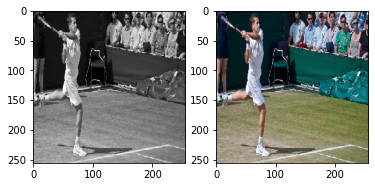

In [8]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
i = 0
for bw_image, cl_image in zip(bw_image_generator, cl_image_generator):
  if(i<123):
    i+=1
    continue
  bw = np.concatenate((bw_image,)*3, axis=-1)
  axarr[0].imshow(bw[0])
  axarr[1].imshow(cl_image[0])
  break

In [9]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def build_generator(channels, image_shape = (720,720,1)):
    inputs = Input(shape=image_shape)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 32, 32, 64)
        downsample(128, 4),  # (bs, 16, 16, 128)
        downsample(256, 4),  # (bs, 8, 8, 256)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
        # downsample(512, 4),  # (bs, 2, 2, 512)
        # downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        # upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(channels, 4,
                            strides=2,
                            padding='same',
                            kernel_initializer=initializer,
                            activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

      # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

We build the discriminator network

In [11]:
def build_discriminator(image_shape=(720,720,3)):

    X_input = Input(shape = image_shape)
    
    resnet50 = ResNet50(include_top=False, weights='imagenet',input_tensor = X_input)
    
    X = resnet50.get_layer('conv3_block4_2_relu').output

    X = Conv2D(filters = 1, kernel_size = 3, strides=1, padding='valid', use_bias=False)(X)

    X = LeakyReLU(alpha=0.2)(X)
    
    # X_input = Input(shape=(256, 256, 3))
    
    # X = Conv2D(filters = 64, kernel_size=4, strides=1, padding='same', use_bias=False)(X_input)
    # X = BatchNormalization(momentum=0.8)(X)
    # X = LeakyReLU(alpha=0.2)(X)
    
    # X_shortcut = X
    
    # X = Conv2D(filters = 128, kernel_size=4, strides=2, padding='same', use_bias=False)(X)
    # X = BatchNormalization(momentum=0.8)(X)
    # X = LeakyReLU(alpha=0.2)(X)
    # X = Conv2D(filters = 64, kernel_size=1, strides=1, padding='same', use_bias=False)(X)
    # X = BatchNormalization(momentum=0.8)(X)
    # X = LeakyReLU(alpha=0.2)(X)
    
    # X_shortcut = GlobalAveragePooling2D()(X_shortcut)
    # X_shortcut = Reshape((1,1,64))(X_shortcut)
    # X_shortcut = Conv2D(filters = 16, kernel_size=1, strides=1, padding='same', use_bias=False)(X_shortcut)
    # X_shortcut = LeakyReLU(alpha=0.3)(X_shortcut)
    # X_shortcut = Conv2D(filters = 64, kernel_size=1, strides=1, padding='same', use_bias=False)(X_shortcut)
    
    # X = Multiply()([X, X_shortcut])
    # X = LeakyReLU(alpha=0.2)(X)
    
    # X = Conv2D(filters = 256, kernel_size=4, strides=1, padding='same', use_bias=False)(X)
    # X = BatchNormalization(momentum=0.8)(X)
    # X = LeakyReLU(alpha=0.2)(X)
    
    # X_shortcut = X
    
    # X_shortcut = GlobalAveragePooling2D()(X_shortcut)
    # X_shortcut = Reshape((1,1,256))(X_shortcut)
    # X_shortcut = Conv2D(filters = 32, kernel_size=1, strides=1, padding='same', use_bias=False)(X_shortcut)
    # X_shortcut = LeakyReLU(alpha=0.3)(X_shortcut)
    # X_shortcut = Conv2D(filters = 256, kernel_size=1, strides=1, padding='same', use_bias=False)(X_shortcut)
    
    # X = Multiply()([X, X_shortcut])
    # X = LeakyReLU(alpha=0.2)(X)
    
    
    # X = Conv2D(filters = 256, kernel_size=4, strides=1, padding='same', use_bias = False)(X)
    # X = BatchNormalization(momentum=0.8)(X)
    # X = LeakyReLU(alpha=0.2)(X)

    # X = Dropout(0.25)(X)
    # X = Conv2D(filters = 512, kernel_size=4, strides=1, padding='same', use_bias=False)(X)
    # X = BatchNormalization(momentum=0.8)(X)
    # X = LeakyReLU(alpha=0.2)(X)
    
    # X_shortcut = Conv2D(filters = 512, kernel_size = 4, strides=1, padding='same', use_bias=False)(X_shortcut)
    # X_shortcut = BatchNormalization(momentum=0.8)(X_shortcut)
    # X_shortcut = LeakyReLU(alpha=0.2)(X_shortcut)
    
    # X = Add(name='addition_layer')([X,X_shortcut])

    # X = Conv2D(filters = 1, kernel_size = 3, strides=2, padding='valid', use_bias=False)(X)
    
    model = Model(inputs = X_input, outputs = X, name='Discriminator')

    for layer in model.layers[:-10]:
        layer.trainable = False

    return model

Let's create an instance of network optimizers. We'll use them later on to apply weights using gradient tape. For now, we'll just initialize them with appropriate names

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)

We see how our generator network performs with initialized weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


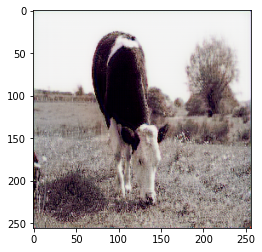

In [13]:
#generator = build_generator(GEN_IMAGE_CHANNELS,(GENERATE_SQUARE,GENERATE_SQUARE,INPUT_IMAGE_CHANNELS))
generator = load_model('drive/My Drive/BE_project/generator independent/training/ResNet18ColorizingGenerator.h5', compile=False)

bw_image = bw_image_generator.next()

generated_image = generator(bw_image, training=False)

plt.imshow(generated_image[0, :, :])

Our discriminator provides us with little to no result

In [14]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,GEN_IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision[0])

94773248/94765736 [==============================] - 1s 0us/step
tf.Tensor(
[[[ 6.18362188e-01]
  [ 6.18411779e-01]
  [ 6.78913474e-01]
  [ 7.08346665e-01]
  [ 6.91472054e-01]
  [ 6.87493086e-01]
  [ 6.75833881e-01]
  [ 6.67047977e-01]
  [ 6.64547682e-01]
  [ 6.31007969e-01]
  [ 6.91160142e-01]
  [ 7.01905489e-01]
  [ 6.82255626e-01]
  [ 6.77184224e-01]
  [ 6.96404576e-01]
  [ 6.97606683e-01]
  [ 6.83565497e-01]
  [ 6.86395228e-01]
  [ 6.88421845e-01]
  [ 6.92543089e-01]
  [ 6.91960335e-01]
  [ 6.90615654e-01]
  [ 6.88833952e-01]
  [ 6.86766088e-01]
  [ 6.88270509e-01]
  [ 6.87834263e-01]
  [ 7.57284164e-01]
  [ 1.91813320e-01]
  [ 1.29948568e+00]
  [-2.72852212e-01]]

 [[ 5.72150946e-01]
  [ 5.14560521e-01]
  [ 4.88312483e-01]
  [ 5.59445500e-01]
  [ 5.76120973e-01]
  [ 5.78647852e-01]
  [ 5.60933530e-01]
  [ 5.15483618e-01]
  [ 4.58767653e-01]
  [ 4.16435063e-01]
  [ 4.22510445e-01]
  [ 3.17712754e-01]
  [ 3.91663343e-01]
  [ 4.77310866e-01]
  [ 5.11411548e-01]
  [ 5.02981186e-01]
  

We're setting up the loss function for our generator and discriminator. That's the log loss or the binary crossentropy loss defined accordingly in the report

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

    # Generator loss = log(y) - log(1-D(x)) + l1(y', G(x))*Lambda

The train step is where we'll process a batch of images and calculate the loss of generator and discriminator. We'll apply the gradient descent values to the variables

In [16]:
@tf.function
def train_step(bw_images, cl_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Get the generated image batch by passing the grayscale images through the generator
        generated_images = generator(bw_images, training=True)
        
        real_output = discriminator(cl_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        #Calculate the losses of the networks
        gen_loss = generator_loss(fake_output, generated_images, cl_images)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #Get the gradients using gradient tape
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        #Apply the gradients so update variables
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return gen_loss, disc_loss

In [17]:
#This cell contains all the "callback" type functionalities
def save_images(cnt,bw_images, cl_images):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

    generated_images = generator.predict(bw_images)

    generated_images = 0.5 * generated_images + 0.5

    bw_image = np.concatenate((bw_images[0],)*3, axis = -1)

    original_image = cl_images[0]

    final_images = np.array([bw_image,generated_images[0],original_image])

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+8) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+8) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = final_images[image_count] * 255
            image_count += 1


    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)


def csv_logger(dictionary, field_names, file_name, header=False):
  mode = 'a'
  if(header):
    mode = 'w'
    print(f'Creating file {file_name} in mode:{mode}')
  with open(file_name, mode) as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    if(header):
      writer.writeheader()
    writer.writerow(dictionary)

In [23]:
def train(gen_generator, disc_generator, epochs, steps_per_epoch):
    start = time.time()
    metrics = {'gen_loss':[], 'disc_loss':[]}
    field_names = ['Epoch', 'gen_loss', 'disc_loss']

    header = True
    for epoch in range(epochs):
        progbar = tf.keras.utils.Progbar(steps_per_epoch)
        epoch_start = time.time()
        if(epoch>0):
          header = False
            
        gen_loss_list = []
        disc_loss_list = []
        
        bw_batch = []
        cl_batch = []
        
        steps = 0

        print(f"Epoch {epoch+1}:")
        
        for bw_imagebatch, cl_imagebatch in zip(gen_generator,disc_generator):
            if(steps>steps_per_epoch):
                break
            if(len(bw_batch)<8):
                for i in range(bw_imagebatch.shape[0]):
                    bw_batch.append(bw_imagebatch[i])
                    cl_batch.append(cl_imagebatch[i])
            t = train_step(bw_imagebatch, cl_imagebatch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            if(steps<steps_per_epoch):
              progbar.update(steps+1)
            steps+=1

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        gen_loss = np.round(g_loss.numpy(),5)
        disc_loss = np.round(d_loss.numpy(),5)

        metrics['gen_loss'].append(g_loss.numpy())
        metrics['disc_loss'].append(d_loss.numpy())

        #Log the epoch losses
        log = {'Epoch': epoch+1, 'gen_loss': g_loss.numpy(), 'disc_loss': d_loss.numpy()}
        csv_logger(log, field_names, log_file, header)

        epoch_elapsed = time.time()-epoch_start
        
        print (f'gen loss={gen_loss:.4f},disc loss={disc_loss:.4f}, epoch_time={hms_string(epoch_elapsed)}')
        save_images(epoch,np.array(bw_batch), np.array(cl_batch))

        # if(prev_gen_loss > gen_loss):
        #   print(f"Generator Loss reduced from {prev_gen_loss:.4f} to {gen_loss:.4f}")
        #   path = os.path.join(DATA_PATH,f"{FILENAME}.h5")
        #   print(f'Saving model weights to {path}')
        #   generator.save(path)
        # else:
        #   print(f'Generator Loss did not improve')

        # if(len(metrics['loss'])>10):
        #   if(abs(metrics['loss'][-1] - metrics['loss'][-10])< 0.0001):
        #     print(f'Loss did not improve, Early stopping')
        #     break
        # print()

        if(epoch%2 == 0):
          path1 = os.path.join(DATA_PATH,f"{FILENAME}_generator.h5")
          generator.save(path1)
          path2 = os.path.join(DATA_PATH, f"{FILENAME}_discriminator.h5")
          print(f'Saving model weights to {path1, path2}')

        
        # prev_loss = curr_loss

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

    return metrics

In [24]:
print(generator.summary())
print()
print(discriminator.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 1088        input_6[0][0]                    
__________________________________________________________________________________________________
stage1_unit1_bn1 (BatchNormaliz (None, 256, 256, 64) 256         conv2d_5[0][0]                   
__________________________________________________________________________________________________
stage1_unit1_relu1 (Activation) (None, 256, 256, 64) 0           stage1_unit1_bn1[0][0]           
____________________________________________________________________________________________

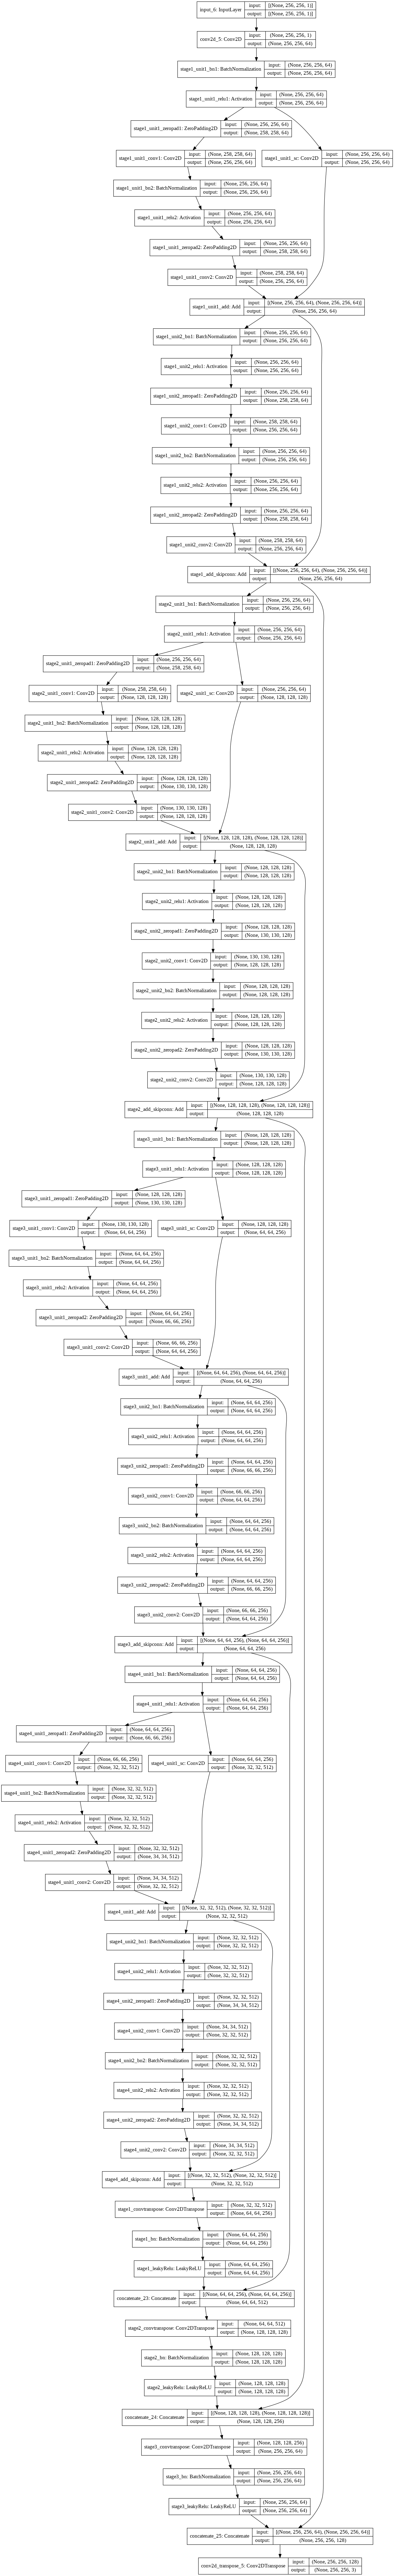

In [20]:
#Plot model only when necessary


tf.keras.utils.plot_model(
    generator,
    to_file = 'generator.png',
    show_shapes = True,
    show_layer_names = True,
    expand_nested = True,
    dpi = 96
)


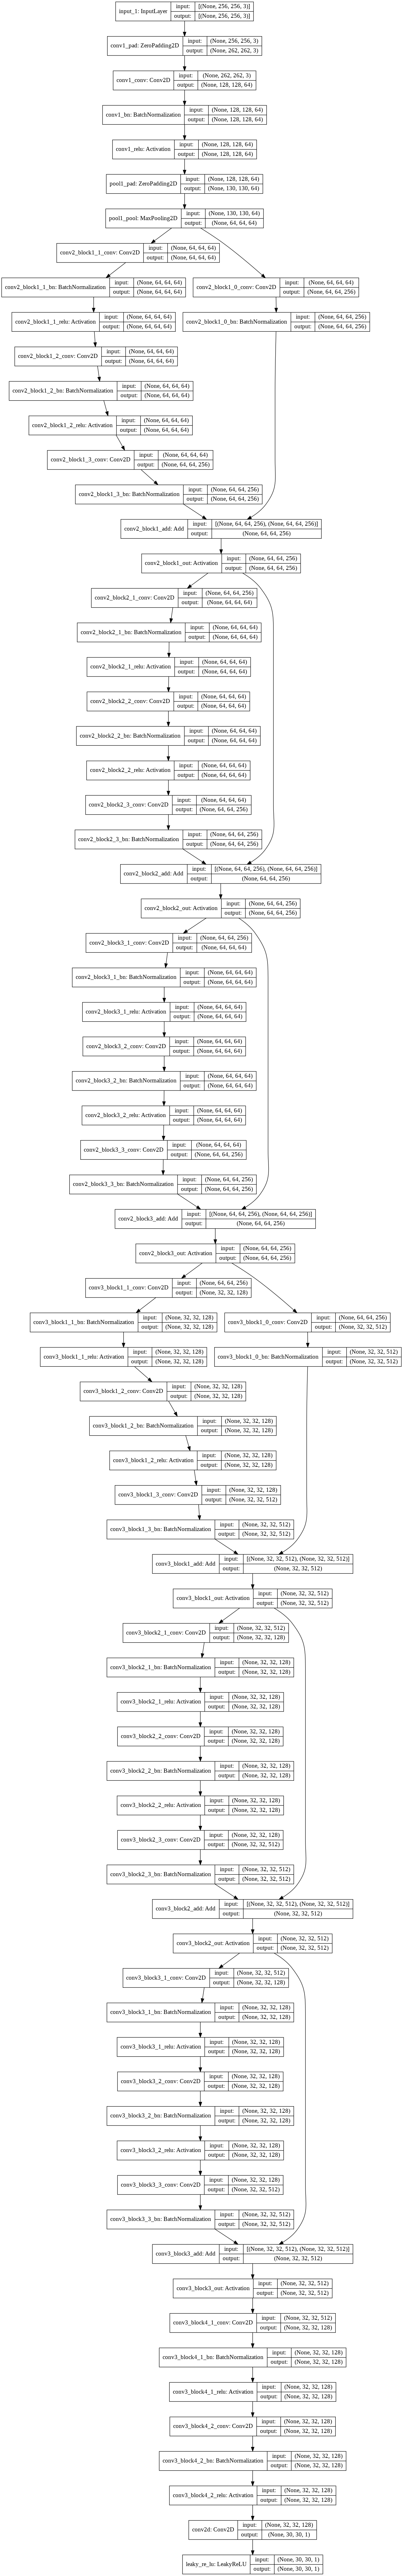

In [21]:
#Plot model only when necessary


tf.keras.utils.plot_model(
    discriminator,
    to_file = 'discriminator.png',
    show_shapes = True,
    show_layer_names = True,
    expand_nested = True,
    dpi = 96
)


In [ ]:
steps_per_epoch = int(np.ceil(bw_image_generator.n/bw_image_generator.batch_size))

bw_image_generator.reset()
cl_image_generator.reset()
history = train(bw_image_generator, cl_image_generator, EPOCHS, steps_per_epoch)

Epoch 1:
 368/1000 [==========>...................] - ETA: 7:38

In [ ]:
generator.save(os.path.join(DATA_PATH,f"{FILENAME}.h5"))